In [1]:
# Импортируем необходимые инструменты

# Data
import pandas as pd
import numpy as np
from scipy.sparse import hstack


# NLP
import nltk
import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

# ML
import sklearn

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from catboost import Pool, CatBoostClassifier

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt

# My preprocessing tools
from utils import *

In [2]:
# Настроим расположение файлов для работы в Google Colab или на своем рабочем месте

try:
    from google.colab import drive
    is_in_colab = True
except:
    is_in_colab = False

if is_in_colab:
    nltk.download('stopwords')
    nltk.download('wordnet')
    drive.mount('/content/drive')
    data_folder = r'/content/drive/My Drive/Colab/toxic/'
else:
    data_folder = r'./data/'


In [3]:
# Загружаем необходимые данные: датасет, стоп слова, ненормативная лексика.
# Я заранее подготовил текстовый файл "badwords.txt" со списком ненормативной лексики.

stop_words = set(stopwords.words('english'))
with open(data_folder + 'badwords.txt') as file:  
  bad_words = set(file.read().split('\n'))
data = pd.read_csv(data_folder + '/train.csv')

## Посмотрим данные

In [4]:
data.head(10)

,comment_text,toxic
0,Barcelona football seasons (early 20th century...,0
1,"""\n\n answering questions \n\nI won't have a c...",0
2,"""\n\nIssues\nOnefortyone, the reason why I rem...",0
3,"""\nIn that case would """"new age"""" at least be ...",0
4,"Mr. Wolf,\nWe need to have a serious talk abou...",0
5,"""Please note that DPeterson has now starting a...",0
6,Bald Eagle\nI've addressed all your points so ...,0
7,"SARAH \n\nYou deleted it, but it remains. I em...",0
8,Rand Paul \n\nAre you monitoring Rand Paul? I...,0
9,Poor AFD rationales \n Wikipedia:Articles for ...,0


У нас 2 колонки: комментарий и класс

In [5]:
# Узнаем количество классов
data.toxic.nunique()

2

Перед нами задача бинарной классификации.

0.09071466196190923

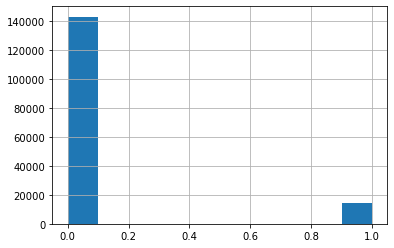

In [6]:
# Узнаем соотношение классов
data.toxic.hist()
data.toxic.mean()

К сожалению, мы имеем дело с несбалансированными данными. Теперь нам необходимо выбрать метрику оценки качества предсказаний. Для несбалансированных данных мы не можем использовать accuracy, поскольку если все время предсказывать нулевой класс, то мы получим accuracy 0.9. В тоже время precision и recall будут равны 0, поэтому мы можем использовать F1 для оценки качества предсказаний. Кроме F1, адекватными метриками могут послужить cohen_kappa_score и roc_auc_score. Мы будем использовать F1.

In [7]:
# Проверим nan
data.isna().any()

comment_text    False
toxic           False
dtype: bool

In [8]:
# Проверим на сколько длиные тексты в нашем датасете. 
# А заодно начнем искать признаки, для этого посмотрим как отличаются средние длины токсичных и нетоксичных комментариев и как отличается разброс значений.

lens = data.comment_text.str.len()
print('All data:\n',f'Mean: {lens.mean():.2f}\nStandard deviation: {lens.std():.2f}\nMax: {lens.max():.2f}\nMin: {lens.min():.2f}\n\n')
lens = data.comment_text[data.toxic == 1].str.len()
print('Toxic comments:\n', f'Mean: {lens.mean():.2f}\nStandard deviation: {lens.std():.2f}\nMax: {lens.max():.2f}\nMin: {lens.min():.2f}\n\n')
lens = data.comment_text[data.toxic == 0].str.len()
print('Non-toxic comments:\n', f'Mean: {lens.mean():.2f}\nStandard deviation: {lens.std():.2f}\nMax: {lens.max():.2f}\nMin: {lens.min():.2f}\n\n')

All data:
 Mean: 394.34
Standard deviation: 589.64
Max: 5000.00
Min: 6.00


Toxic comments:
 Mean: 293.02
Standard deviation: 608.56
Max: 5000.00
Min: 8.00


Non-toxic comments:
 Mean: 404.45
Standard deviation: 586.76
Max: 5000.00
Min: 6.00




Среди всех комментариев встречаются длинные тексты. Мы видим, что токсичные комментарии короче.

## Baseline

In [9]:
# В качестве признаков, описывающих тексты, мы будем использовать TF-IDF. 
# Зачастую Count vectorizer дает хорошие результаты, но для облегчения процесса обучения, мы будем использовать именно TF-IDF, 
# поскольку полученные значения будут меньше.
# Мы будем ипользовать в качестве признаков не только слова, но и отдельные символы. Такой подход дает лучшие результаты.

word_vectorizer = TfidfVectorizer(                                  # Vectorizer для слов
    analyzer='word',                                                # Слова в качестве признаков
    token_pattern=r'\w{1,}',                                        # Шаблон для извлечения токенов
    stop_words=stop_words,                                          # Избавимся от стоп-слов
    ngram_range=(1, 1),                                             # Не используем n-грамы
    max_features=20000,                                             # Максимальное количество признаков
    max_df=0.5)                                                     # Не будем использовать токены, встречающиеся более чем в 50 процентов документов


char_vectorizer = TfidfVectorizer(                        # Vectorizer для символов
    analyzer='char',                                      # Символы в качестве признаков
    stop_words='english',                                 # Избавимся от стоп-слов
    ngram_range=(1, 4),                                   # Используем различные n-граммы
    max_features=30000,                                   # Максимальное количество признаков
    max_df=0.5                                            # Не будем использовать токены, встречающиеся более чем в 50 процентов документов
    )


# Создадим матрицы признаков для тренировочных данных
train_w_features = word_vectorizer.fit_transform(data.comment_text)
train_c_features = char_vectorizer.fit_transform(data.comment_text)

# Объединим все признаки в одну матрицу
train_features = hstack([train_w_features, train_c_features])

In [10]:
# Наш класиификатор - Logistic Regression
model = LogisticRegression(solver='sag')

# Кросс валидация
cv_score = np.mean(cross_val_score(model, train_features, data.toxic, cv=3, scoring='f1'))
print('CV score is {}'.format(cv_score))

CV score is 0.7603415794068896


Также натренируем catboost, в котором есть text_features.

In [11]:
def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train,
        text_features=['comment_text'],
        feature_names=['comment_text']
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        text_features=['comment_text'],
        feature_names=['comment_text']
    )
    
    catboost_default_params = {
        'iterations': 1000,
        'learning_rate': 0.05,
        'eval_metric': 'F1',
        'task_type': 'GPU'
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

X_train, X_test, y_train, y_test = train_test_split(data[['comment_text']], data.toxic.values, test_size=0.33, random_state=42)
cat_boost_model = fit_catboost(X_train, X_test, y_train, y_test)

0:	learn: 0.6428693	test: 0.6808118	best: 0.6808118 (0)	total: 18ms	remaining: 18s
100:	learn: 0.6466302	test: 0.6742996	best: 0.6808118 (0)	total: 1.67s	remaining: 14.8s
200:	learn: 0.6624235	test: 0.6806702	best: 0.6814869 (189)	total: 3.3s	remaining: 13.1s
300:	learn: 0.6696244	test: 0.6848750	best: 0.6850346 (298)	total: 4.91s	remaining: 11.4s
400:	learn: 0.6765890	test: 0.6847945	best: 0.6853946 (338)	total: 6.52s	remaining: 9.75s
500:	learn: 0.6820485	test: 0.6852259	best: 0.6866472 (429)	total: 8.14s	remaining: 8.11s
600:	learn: 0.6851456	test: 0.6861260	best: 0.6874237 (589)	total: 9.81s	remaining: 6.51s
700:	learn: 0.6897311	test: 0.6859029	best: 0.6874237 (589)	total: 11.5s	remaining: 4.88s
800:	learn: 0.6933936	test: 0.6863369	best: 0.6874237 (589)	total: 13.1s	remaining: 3.25s
900:	learn: 0.6974754	test: 0.6861761	best: 0.6874237 (589)	total: 14.7s	remaining: 1.62s
999:	learn: 0.7002507	test: 0.6859524	best: 0.6874237 (589)	total: 16.4s	remaining: 0us
bestTest = 0.687423687

Мы получили F1 = 0.687 на тестовых даных. Чтобы улучшить catboost мы можем использовать n-грамы. Но сосредоточимся на улучшении Logistic Regression, которая набрала F1 = 0.689

## Preprocessing and finding new features

Предобработка текстов включает в себя такие процессы, как токенизация; лемматизация; очистка, которая может избавить от стоп-слов, пунктуации, различных симоволов и сущностей; разметка (морфологическая, синтаксическая и пр.); первод символов в нижний регистр и т.д.

Наиболее быстрым способом предобработать тексты позволяют регулярные выражения. Обычно я их использую, чтобы быстро проверить гипотезы о важности токенов для модели. Я определил функцию utils.regexp_tokenizer(texts, lemmatizer, stop_words), в которой основной шаблон для поиска токенов:
```
\w+\d+\w+?|\d+\w+|(?:\w\s)+|(?:\w\s?\.\s?)+\w?|\w+\.+\w+|\w+'\w+|#?\w+-?\w+|\w+[\*\$]+\w+?
```

Также функция принимает лемматизатор, я использовал WordNetLemmatizer.


In [12]:
lemmatizer = WordNetLemmatizer()
lemmatized_texts = regexp_tokenizer(data.comment_text, lemmatizer, stop_words)

  2%|█▌                                                                         | 3239/157571 [00:03<11:50, 217.12it/s]


No tokens for text:
 1993

1994

1995

1996

1997

1998

1999

2000

2001

2002

2003


  3%|██▎                                                                       | 4966/157571 [00:04<01:43, 1468.06it/s]


No tokens for text:
 193.61.111.53  15:00


 10%|███████▏                                                                 | 15613/157571 [00:10<01:17, 1828.97it/s]


No tokens for text:
 ~ 

68.193.147.157


 32%|███████████████████████▌                                                 | 50769/157571 [00:28<00:56, 1879.44it/s]


No tokens for text:
 14:53,


 33%|████████████████████████                                                 | 51926/157571 [00:29<00:57, 1845.65it/s]


No tokens for text:
 92.24.199.233|92.24.199.233]]


 38%|███████████████████████████▊                                             | 59911/157571 [00:33<00:54, 1807.30it/s]


No tokens for text:
 "

 199.209.144.211  "


 51%|█████████████████████████████████████▍                                   | 80860/157571 [00:44<00:39, 1930.00it/s]


No tokens for text:
 "
 '''''' 2010/2013 "


100%|███████████████████████████████████████████████████████████████████████▉| 157564/157571 [01:23<00:00, 1876.39it/s]


In [13]:
data.comment_text[:2].values

array(["Barcelona football seasons (early 20th century) \n\nI looked at the Barcelona football seasons for which you added  (and some other seasons after). They could do with , really. (I don't think it's worth listing at WP:PNT, but this should put them in view of  one way or another, or if not that could be added to their talk pages). I don't want to do it myself (a) because I am lazy and (b) because I know nothing about football and would probably make translation mistakes.",
       '"\n\n answering questions \n\nI won\'t have a chance to say hello or goodbye when I\'m blocked/banned/whatever. So, ""Hello; I\'m not holding my breath on anyone addressing your questions concerning Dawn Well\'s page on Wiki; and I better get in a good-bye, as I feel I have the lifespan of a May fly in a low ceilinged room full of bullfrogs; not because I’m wrong, but because anyone on your side of the issue is going to be attacked and baited into some infraction, an infraction ignored by someone they l

In [14]:
lemmatized_texts[:2]

['barcelona football season early th century looked barcelona football season added season could really think worth listing wp pnt put view one way another could added talk page want lazy know nothing football would probably make translation mistake',
 "answering question chance say hello goodbye i'm blocked banned whatever hello i'm holding breath anyone addressing question concerning dawn well's page wiki better get good-bye feel lifespan may fly low ceilinged room full bullfrog wrong anyone side issue going attacked baited infraction infraction ignored someone like infraction worthy execution committed"]

Как мы видим, для некоторых текстов не нашлось токенов. Это из-за того, что я игнорировал цифры, знаки пунктуации, а сосредоточился только на словах. Стоит отметить, что для достижения наилучших результатов на нашем датасете, возможно, стоит использовать ip адреса, даты и прочее.

В процессе исследования стало понятно, что spacy со своим лемматизатором без очистки, кроме стоп-слов, показывает лучшие результаты, нежели мой regexp_tokenizer() и сама spacy с очисткой от пунктуации и прочих символов. Но у таких инструментов, как spacy есть существенный минус, они требуют больше времени, чем регулярные выражения. Предобработка с помощью spacy заняла у меня более 50 минут. Кроме того, spacy позволяет получить части речи, что также стоит использовать как дополнительный признак для текстов. Интуиция здесь следующая - в токсичных комментариях грамматические формы отличаются от форм, которые используются в обычных комментариях. Я не нашел, как получить тэги для всех морфем словоформы в spacy (в mystem такое есть), поэтому использовал только части речи.

In [15]:
# spacy_lemmatizer возвращает (lemmatized_texts, tags) 
#nlp = spacy.load("en_core_web_sm")
#data['lemmatized_text'], data['tags'] = spacy_lemmatizer(data.comment_text, nlp)


# я сохранил у себя на диске предобработанный датасет, поэтому буду пользоваться им 
data = pd.read_csv(data_folder + '/train_spacy3_tagged.csv')
data = data[['comment_text', 'lemmatized_text', 'tags', 'toxic']]

In [16]:
data.head(10)

,comment_text,lemmatized_text,tags,toxic
0,Barcelona football seasons (early 20th century...,barcelona football season ( early 20th century...,NNP NN NNS -LRB- JJ JJ NN -RRB- _SP PRP VBD IN...,0
1,"""\n\n answering questions \n\nI won't have a c...",""" \n\n answer question \n\n -pron- will not h...",`` _SP VBG NNS _SP PRP MD RB VB DT NN TO VB UH...,0
2,"""\n\nIssues\nOnefortyone, the reason why I rem...",""" \n\n issue \n onefortyone , the reason why -...","`` _SP NNS _SP NNP , DT NN WRB PRP VBD PRP$ NN...",0
3,"""\nIn that case would """"new age"""" at least be ...",""" \n in that case would "" "" new age "" "" at lea...",`` _SP IN DT NN MD `` `` JJ NN '' `` IN JJS VB...,0
4,"Mr. Wolf,\nWe need to have a serious talk abou...","mr. wolf , \n -pron- need to have a serious ta...","NNP NNP , _SP PRP VBP TO VB DT JJ NN IN NNP . ...",0
5,"""Please note that DPeterson has now starting a...",""" please note that dpeterson have now start ac...",`` UH VB IN NNP VBZ RB VBG VBG PRP IN NN IN VB...,0
6,Bald Eagle\nI've addressed all your points so ...,bald eagle \n -pron- have address all -pron- p...,NNP NNP _SP PRP VB VBN DT PRP$ NNS RB RB . NNS...,0
7,"SARAH \n\nYou deleted it, but it remains. I em...","sarah \n\n -pron- delete -pron- , but -pron- r...","NNP _SP PRP VBD PRP , CC PRP VBZ . PRP VBD NN ...",0
8,Rand Paul \n\nAre you monitoring Rand Paul? I...,rand paul \n\n be -pron- monitor rand paul ? ...,"NNP NNP _SP VBP PRP VBG NNP NNP . _SP IN RB , ...",0
9,Poor AFD rationales \n Wikipedia:Articles for ...,poor afd rationale \n wikipedia : article for...,JJ NNP VBZ _SP NNP : NNS IN NN SYM NNP NNP NNP...,0


In [17]:
# Посчитаем количество токенов и количество редких токенов
all_lemmatized_tokens = [w for t in data.lemmatized_text for w in t.split(' ')]
freq = nltk.probability.FreqDist(all_lemmatized_tokens)
uncommon = {word for (word, count) in freq.most_common() if count == 1}
print('Tokens: ', len(all_lemmatized_tokens))
print('Rare tokens: ', len(uncommon))

Tokens:  13442636
Rare tokens:  122115


У нас большое количество токенов, которые встречаются один раз. Здесь можно было бы применить spell correction с помощью TextBlob или других библиотек, но они не справляются со словами, вроде "hiiiii", "heeeeeeellooooo".

Теперь подумаем, какие количественные признаки еще мы можем извлечь из текстов.
1. Количество ненормативной лексики относительно всех слов в тексте. Это совершенно очевидно, что подобный признак будет полезен.
2. Количество заглавных букв относительно всех символов в тексте. Зачастую можно встретить токсичные комментарии, состоящие только из заглавных букв.
3. Количество специальных симовлов (эмодзи, разлиные редкие символы, символы, которыми можно что-то изобразить, и пр.). В датасете часто встречаются токсичные комментарии, которые в большей степени состоят из символов. Например: """=P=\n=E=\n=N=\n=I=\n ... """
4. Количество уникальных слов, относительно всех слов текста. Совершенно понятно, что активная лексика в токсичных комментариях не такая обширная.
5. Количество восклицательных знаков.
6. Количество "добрых" эмодзи, смайликов.
7. Длина текста.

Я буду использовать 1-4. Для этого я подготовил функции в utils



In [18]:
character_list = get_list_of_special_characters(data.comment_text)

data['nbadwords'] = get_nbadwords(data.lemmatized_text, bad_words)   # 1
data['ncapitals'] = get_ncapitals(data.comment_text)                 # 2
data['nspecial'] = get_nspecial(data.comment_text, character_list)   # 3
data['nuniquewords'] = get_nuniquewords(data.lemmatized_text)        # 4

In [19]:
data.head(10)

,comment_text,lemmatized_text,tags,toxic,nbadwords,ncapitals,nspecial,nuniquewords
0,Barcelona football seasons (early 20th century...,barcelona football season ( early 20th century...,NNP NN NNS -LRB- JJ JJ NN -RRB- _SP PRP VBD IN...,0,0.009009,0.027601,0.010616,0.576577
1,"""\n\n answering questions \n\nI won't have a c...",""" \n\n answer question \n\n -pron- will not h...",`` _SP VBG NNS _SP PRP MD RB VB DT NN TO VB UH...,0,0.007634,0.022453,0.006908,0.580153
2,"""\n\nIssues\nOnefortyone, the reason why I rem...",""" \n\n issue \n onefortyone , the reason why -...","`` _SP NNS _SP NNP , DT NN WRB PRP VBD PRP$ NN...",0,0.006369,0.029891,0.001359,0.547771
3,"""\nIn that case would """"new age"""" at least be ...",""" \n in that case would "" "" new age "" "" at lea...",`` _SP IN DT NN MD `` `` JJ NN '' `` IN JJS VB...,0,0.000000,0.015152,0.015152,0.750000
4,"Mr. Wolf,\nWe need to have a serious talk abou...","mr. wolf , \n -pron- need to have a serious ta...","NNP NNP , _SP PRP VBP TO VB DT JJ NN IN NNP . ...",0,0.005848,0.078608,0.002577,0.467836
5,"""Please note that DPeterson has now starting a...",""" please note that dpeterson have now start ac...",`` UH VB IN NNP VBZ RB VBG VBG PRP IN NN IN VB...,0,0.011494,0.026247,0.000000,0.597701
6,Bald Eagle\nI've addressed all your points so ...,bald eagle \n -pron- have address all -pron- p...,NNP NNP _SP PRP VB VBN DT PRP$ NNS RB RB . NNS...,0,0.000000,0.079365,0.000000,0.875000
7,"SARAH \n\nYou deleted it, but it remains. I em...","sarah \n\n -pron- delete -pron- , but -pron- r...","NNP _SP PRP VBD PRP , CC PRP VBZ . PRP VBD NN ...",0,0.000000,0.056604,0.000000,0.687500
8,Rand Paul \n\nAre you monitoring Rand Paul? I...,rand paul \n\n be -pron- monitor rand paul ? ...,"NNP NNP _SP VBP PRP VBG NNP NNP . _SP IN RB , ...",0,0.032258,0.062500,0.008929,0.677419
9,Poor AFD rationales \n Wikipedia:Articles for ...,poor afd rationale \n wikipedia : article for...,JJ NNP VBZ _SP NNP : NNS IN NN SYM NNP NNP NNP...,0,0.035714,0.111940,0.014925,0.678571


Посморим как коррелируют новые признаки с классами.

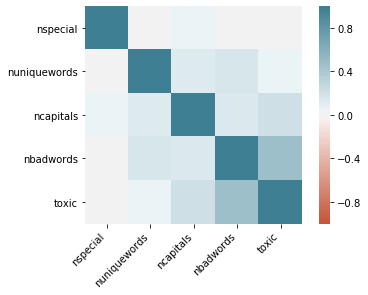

In [20]:
# Построим тепловую карту для матрицы корреляций признаков и целевого значения
corr = data[['nspecial', 'nuniquewords', 'ncapitals', 'nbadwords', 'toxic']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Целевой признак хорошо коррелирует с ненормативной лексикой и заглавными буквами. Остальные признаки коррелируют незначительно.

## Final training and evaluating

Сначала извлекаем новые признаки и объединяем их.

In [21]:
word_vectorizer = TfidfVectorizer(
    analyzer='word',                                 
    tokenizer=split_tokenizer,                       # Все токены разделены пробелом, поэтому токенизируем разделением по ' '
    stop_words='english',                             
    ngram_range=(1, 1),
    max_features=20000,                              
    max_df=0.5)                                      # и мы не учитываем токены, которые встречаются более чем в 50 процентов текстов.

char_vectorizer = TfidfVectorizer(                   # Также используем символьные n-грамы из исходных текстов в качестве признаков
    analyzer='char',
    stop_words='english',
    ngram_range=(1, 4),
    max_features=20000,
    max_df=0.5)

tag_vectorizer = TfidfVectorizer(                   # Извлечем признаки из частей речи в текстах.
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=10000,
    max_df=0.5)

train_w_features = word_vectorizer.fit_transform(data.lemmatized_text)
train_c_features = char_vectorizer.fit_transform(data.comment_text)
train_t_features = tag_vectorizer.fit_transform(data.tags)

for w in bad_words:
    if w in word_vectorizer.vocabulary_:
        ind = word_vectorizer.vocabulary_[w]
        train_w_features[:, ind] *= 5.0
    if w in char_vectorizer.vocabulary_:
        ind = char_vectorizer.vocabulary_[w]
        train_c_features[:, ind] *= 5.0


train_features = hstack([train_w_features, train_c_features, train_t_features, 
                         data.nbadwords.values.reshape(-1, 1), data.nuniquewords.values.reshape(-1, 1), 
                         data.nspecial.values.reshape(-1, 1), data.ncapitals.values.reshape(-1,1)])

In [22]:
# Увеличим значения TF-IDF для ненормативной лексики

alpha = 5.0

for w in bad_words:
    if w in word_vectorizer.vocabulary_:
        ind = word_vectorizer.vocabulary_[w]
        train_w_features[:, ind] *= alpha
    if w in char_vectorizer.vocabulary_:
        ind = char_vectorizer.vocabulary_[w]
        train_c_features[:, ind] *= alpha


train_features = hstack([train_w_features, train_c_features, train_t_features, 
                         data.nbadwords.values.reshape(-1, 1), data.nuniquewords.values.reshape(-1, 1), 
                         data.nspecial.values.reshape(-1, 1), data.ncapitals.values.reshape(-1,1)])      

In [30]:
# Посмотрим на топ признаков для разных классов.
top_n = 15

print('TF-IDF scores for non-toxic: \n', sorted(list(zip(word_vectorizer.get_feature_names(), 
                                             train_w_features[data.toxic.values == 0].sum(0).getA1())), 
                                 key=lambda x: x[1], reverse=True)[:top_n])

print('TF-IDF scores for toxic: \n', sorted(list(zip(word_vectorizer.get_feature_names(), 
                                             train_w_features[data.toxic.values == 1].sum(0).getA1())), 
                                 key=lambda x: x[1], reverse=True)[:top_n])

TF-IDF scores for non-toxic: 
 [('', 369835.54010625527), ('"', 14903.215870510438), ('\n\n', 5361.5996355190355), ('god', 4783.520303355421), ('\n', 4418.009772879224), ('?', 4384.392314043034), (')', 4033.7399747456466), ('article', 3938.4806403005623), ('(', 3757.3467954638286), (':', 3751.523026009319), ('-', 3715.2235314174554), ('page', 3534.207398680681), ('!', 3133.8678187249798), ('kill', 3084.1105321054533), ('talk', 3006.6285972064534)]
TF-IDF scores for toxic: 
 [('fuck', 21268.754097442554), ('', 20920.57338504264), ('shit', 7856.964349522259), ('fucking', 7544.92680046646), ('suck', 6957.662831486181), ('bitch', 5621.759681927644), ('ass', 5605.0476591584265), ('stupid', 5557.197139726444), ('asshole', 4765.726561547852), ('dick', 4121.229522515433), ('gay', 4089.893262602097), ('faggot', 4010.221173924781), ('cunt', 3875.2424676853657), ('hell', 3509.072986856047), ('cock', 2486.2879555972972)]


Все кажется вполне адекватным.

In [24]:
# Тренируем модель
model = LogisticRegression(solver='sag')
cv_score = np.mean(cross_val_score(model, train_features, data.toxic, cv=3, scoring='f1'))
print('CV score is {}'.format(cv_score))

C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score is 0.781008259781207


In [28]:
# Посмотрим на результаты catboost
def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train,
        text_features=['comment_text', 'lemmatized_text', 'tags'],
        feature_names=list(X_train)
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        text_features=['comment_text', 'lemmatized_text', 'tags'],
        feature_names=list(X_train)
    )
    
    catboost_default_params = {
        'iterations': 2000,
        'learning_rate': 0.05,
        'eval_metric': 'F1',
        'task_type': 'GPU'
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

X_train, X_test, y_train, y_test = train_test_split(data[[column for column in data.columns if column != 'toxic']],
                                                    data.toxic.values, test_size=0.33, random_state=42)
cat_boost_model = fit_catboost(X_train, X_test, y_train, y_test)

0:	learn: 0.6670440	test: 0.6862795	best: 0.6862795 (0)	total: 19.8ms	remaining: 39.6s
100:	learn: 0.7361347	test: 0.7426901	best: 0.7429963 (98)	total: 1.89s	remaining: 35.6s
200:	learn: 0.7566251	test: 0.7606003	best: 0.7606909 (199)	total: 3.63s	remaining: 32.5s
300:	learn: 0.7695121	test: 0.7673566	best: 0.7673566 (300)	total: 5.35s	remaining: 30.2s
400:	learn: 0.7770147	test: 0.7714623	best: 0.7719340 (396)	total: 7.07s	remaining: 28.2s
500:	learn: 0.7828782	test: 0.7733741	best: 0.7737913 (494)	total: 8.77s	remaining: 26.2s
600:	learn: 0.7864395	test: 0.7739509	best: 0.7742619 (592)	total: 10.5s	remaining: 24.4s
700:	learn: 0.7927057	test: 0.7758742	best: 0.7761474 (691)	total: 12.2s	remaining: 22.6s
800:	learn: 0.7984901	test: 0.7777518	best: 0.7777648 (775)	total: 13.9s	remaining: 20.8s
900:	learn: 0.8016006	test: 0.7784151	best: 0.7784151 (900)	total: 15.6s	remaining: 19.1s
1000:	learn: 0.8050955	test: 0.7786866	best: 0.7792724 (970)	total: 17.3s	remaining: 17.3s
1100:	learn: 

Вполне возможно n-грамы помогут еше улучшить модель. 

Ну, а теперь, чтобы порадовать глаз, можно использовать ROC-AUC =) 

In [26]:
model = LogisticRegression(solver='sag')
cv_score = np.mean(cross_val_score(model, train_features, data.toxic, cv=3, scoring='roc_auc'))
print('CV score is {}'.format(cv_score))

C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score is 0.9773713992871795


## Further actions

Теперь можно посмотреть тексты, где модель ошибается, и построить гипотезы о возможных улучшаениях на стадии предобработки. Далее мы можем попробовать более сложные модели, сделать grid search для подбора лучших параметров моделей. Например, стоит попробовать word embeddings и подавать их на вход LSTM или CNN, а лосс функцию подогнать под целевую метрику. Для достижения лучшего результата по метрикам нужно натренировать много разных моделей, например, Log Reg, Random Forest (к тому же эту модель можно использовать для определения важности признаков), Bagging, Catboost, LSTM, CNN, а затем сделать из них ансамбль. 